# Classifiers - NC - busy vs relaxed - no TFv1
Exploring different classifiers with different autoencoders for the NC task. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [3]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 before starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [4]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [5]:
def get_busy_vs_relax_timeframes_br_hb(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1)."""
    
    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))

        if cog_res['task_label'][task_num_table] != 'NC':
            continue
        
        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)

        try:

            # get extracted features for breathing
            tmpBR_busy = dataextract.extract_from_breathing_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpBR_relax = dataextract_relax.extract_from_breathing_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            #get extracted features for heartbeat
            tmpHB_busy = dataextract.extract_from_heartbeat_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpHB_relax = dataextract.extract_from_heartbeat_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            
            if not (tmpBR_busy['br_ok'][0] and tmpBR_relax['br_ok'][0]):# and tmpHB_busy['hr_ok'] and tmpHB_relax['hr_ok']):
                continue

            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tasks_y, 1))
            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tmp_tasks_y, 0))

            # put busy frames then relaxed frames under the previous frames
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        except ValueError:
#             print(ident)  # ignore short windows
            continue

        # put busy frames then relaxed frames under the previous frames
        tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 1))
        tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 0))

        breathing = np.vstack((breathing, tmp_breathing))

        heartbeat = np.vstack((heartbeat, tmp_heartbeat))

        tasks_data = np.unwrap(tasks_data)
        
    return tasks_data, tasks_y, breathing, heartbeat

In [6]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes

            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [7]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [8]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [9]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [10]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [11]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [12]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [13]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [14]:
def compare_plot_n(data1, data2, plot_n=3):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(1, 5, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(1, 5, i+1)
        plt.plot(data2[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [15]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [16]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

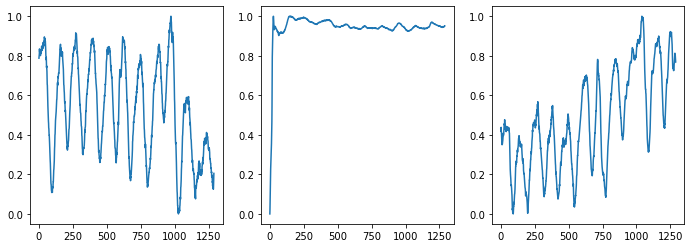

<Figure size 432x288 with 0 Axes>

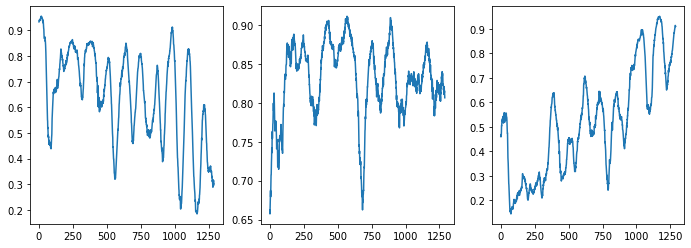

In [17]:
data2 = uc_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

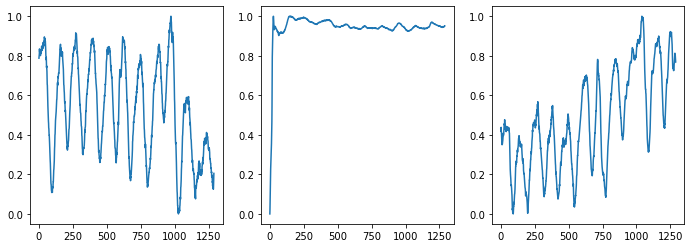

<Figure size 432x288 with 0 Axes>

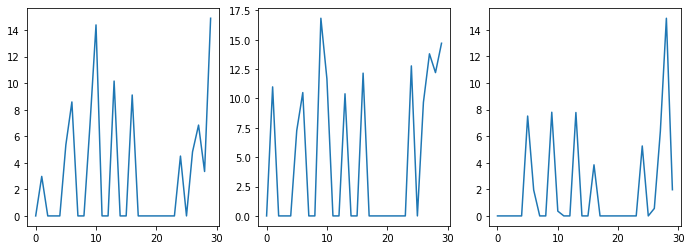

In [18]:
data2 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Store the encoded representations in the data dictionary:

In [19]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    if (phase.shape[0] <= 0):
        uc_data = np.empty((0, encoding_dim))
    else:
        uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [20]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [21]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

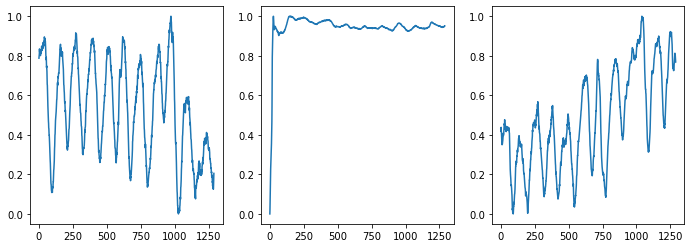

<Figure size 432x288 with 0 Axes>

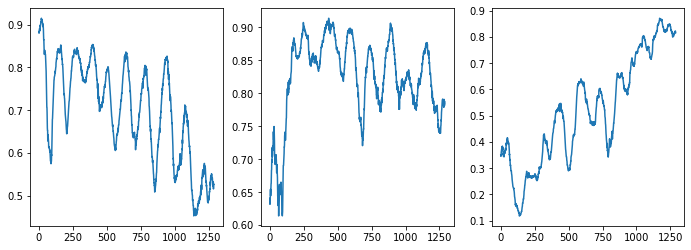

In [22]:
data2 = sp_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

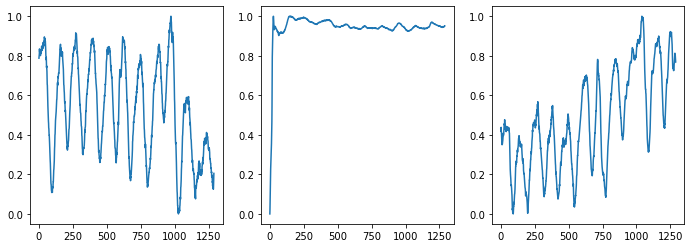

<Figure size 432x288 with 0 Axes>

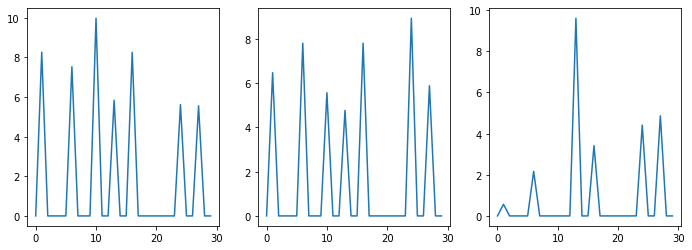

In [23]:
data2 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Store the encoded representations in the data dictionary:

In [24]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    if (phase.shape[0] <= 0):
        sp_data = np.empty((0, encoding_dim))
    else:
        sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [25]:
def deep_ae(x, enc_layers=[512,128], encoding_dim=64, dec_layers=[128,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.125, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [26]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

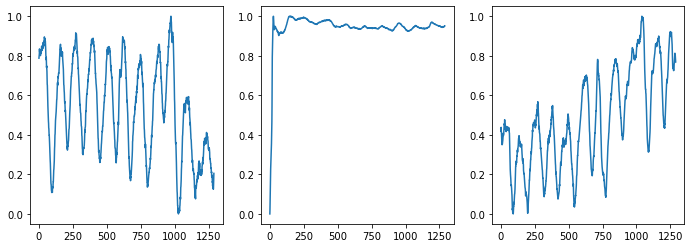

<Figure size 432x288 with 0 Axes>

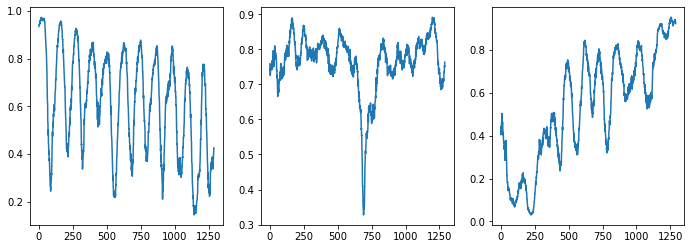

In [27]:
data2 = de_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

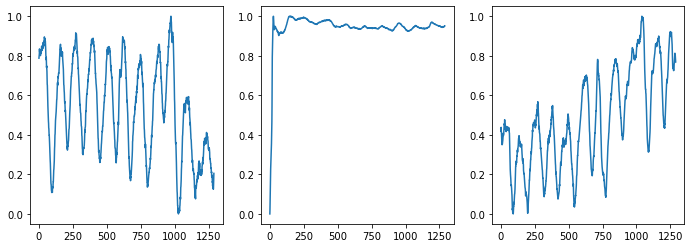

<Figure size 432x288 with 0 Axes>

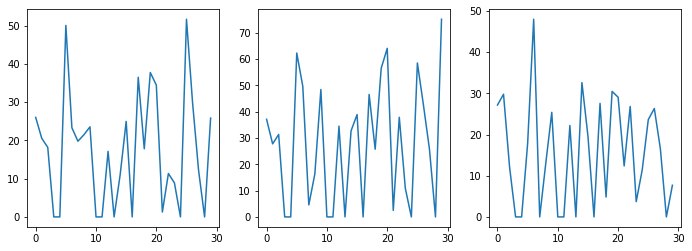

In [28]:
data2 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Store the encoded representations in the data dictionary:

In [29]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    if (phase.shape[0] <= 0):
        de_data = np.empty((0, encoding_dim))
    else:
        de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [30]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [31]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict)
        y_train = train_data[0]
            
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict)
        y_valid = valid_data[0]
        
        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict)
        y_test = test_data[0]
        
        # Skip idents that don't have any data
        if (y_test.shape[0] <= 0 or y_valid.shape[0] <= 0):
            continue
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']

        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            clear_session_and_set_seeds()
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            # Scale data
            if should_scale_data:
                # Scale with standard scaler
                sscaler = StandardScaler()
                sscaler.fit(train_x)
                train_x = sscaler.transform(train_x)

                # Scale valid and test with train's scaler
                valid_x = sscaler.transform(valid_x)
                test_x = sscaler.transform(test_x)
            
            # Initialize variables
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for tmp_index in range(num_loops_to_average_over):
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            # Store accuracy
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [32]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [33]:
params_dense_br_hb = {
    'dropout': 0.05,
    'hidden_size': 24,
    'activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.05,
    'batch_size': 128,
    'epochs': 100
}

In [34]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [35]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_dense_br_hb
    if (data_name == 'phase'):
        params = params_dense_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_dense_ae_enc
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [36]:
accs = helper_loop(dense_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.004986
iteration: 3 of 23 ; time elapsed: 0:00:21.461742
iteration: 4 of 23 ; time elapsed: 0:00:42.663964
iteration: 5 of 23 ; time elapsed: 0:01:02.587307
iteration: 6 of 23 ; time elapsed: 0:01:22.242459
iteration: 7 of 23 ; time elapsed: 0:01:42.438416
iteration: 8 of 23 ; time elapsed: 0:02:03.047468
iteration: 9 of 23 ; time elapsed: 0:02:23.125313
iteration: 10 of 23 ; time elapsed: 0:02:23.129303
iteration: 11 of 23 ; time elapsed: 0:02:23.131297
iteration: 12 of 23 ; time elapsed: 0:02:43.376460
iteration: 13 of 23 ; time elapsed: 0:03:03.518186
iteration: 14 of 23 ; time elapsed: 0:03:23.917851
iteration: 15 of 23 ; time elapsed: 0:03:44.054019
iteration: 16 of 23 ; time elapsed: 0:04:04.208356
iteration: 17 of 23 ; time elapsed: 0:04:24.089252
iteration: 18 of 23 ; time elapsed: 0:04:44.049840
iteration: 19 of 23 ; time elapsed: 0:05:03.864455
iteration: 20 of 23 ; time elapsed: 0:05:23.976

In [37]:
accuracies['simple_dense'] = accs

In [38]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
#pandas.DataFrame.from_dict(accs)

In [39]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.250000   0.500000   0.000000        0.500000       0.166667  0.166667  0.000000
max     1.000000   1.000000   1.000000        1.000000       1.000000  1.000000  1.000000
mean    0.622549   0.691176   0.578431        0.764706       0.612745  0.617647  0.656863
median  0.500000   0.500000   0.500000        0.750000       0.500000  0.500000  0.666667


#### LSTM-based classifier  
based on the original author's code

In [40]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [41]:
params_lstm_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 1,
    'dropout': 0.01,
    'lstm_output_size': 64,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [42]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [43]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_lstm_br_hb
    if (data_name == 'phase'):
        params = params_lstm_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_lstm_ae_enc
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [44]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.004986
iteration: 3 of 23 ; time elapsed: 0:00:39.675860
iteration: 4 of 23 ; time elapsed: 0:01:19.897950
iteration: 5 of 23 ; time elapsed: 0:02:00.072497
iteration: 6 of 23 ; time elapsed: 0:02:39.731532
iteration: 7 of 23 ; time elapsed: 0:03:23.205008
iteration: 8 of 23 ; time elapsed: 0:04:00.790986
iteration: 9 of 23 ; time elapsed: 0:04:37.626515
iteration: 10 of 23 ; time elapsed: 0:04:37.630656
iteration: 11 of 23 ; time elapsed: 0:04:37.633649
iteration: 12 of 23 ; time elapsed: 0:05:14.161257
iteration: 13 of 23 ; time elapsed: 0:05:50.200077
iteration: 14 of 23 ; time elapsed: 0:06:24.765833
iteration: 15 of 23 ; time elapsed: 0:07:00.859207
iteration: 16 of 23 ; time elapsed: 0:07:37.326210
iteration: 17 of 23 ; time elapsed: 0:08:13.511130
iteration: 18 of 23 ; time elapsed: 0:08:49.946620
iteration: 19 of 23 ; time elapsed: 0:09:25.620301
iteration: 20 of 23 ; time elapsed: 0:10:01.668

In [45]:
accuracies['LSTM'] = accs

In [46]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
#pandas.DataFrame.from_dict(accs)

In [47]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse  deep
min     0.250000   0.500000   0.000000        0.500000       0.250000  0.000000   0.0
max     1.000000   1.000000   1.000000        1.000000       1.000000  1.000000   1.0
mean    0.642157   0.696078   0.485294        0.700980       0.544118  0.544118   0.5
median  0.500000   0.500000   0.500000        0.666667       0.500000  0.500000   0.5


#### kNN

In [48]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [49]:
params_knn_br_hb = {
    'n_neighbors': 15,
    'metric': 'manhattan'
}

In [50]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [51]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [52]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_br_hb
    if (data_name == 'phase'):
        params = params_knn_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_knn_ae_enc
    
    model = KNN_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [53]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.003990
iteration: 3 of 23 ; time elapsed: 0:00:00.032940
iteration: 4 of 23 ; time elapsed: 0:00:00.054882
iteration: 5 of 23 ; time elapsed: 0:00:00.077824
iteration: 6 of 23 ; time elapsed: 0:00:00.099762
iteration: 7 of 23 ; time elapsed: 0:00:00.120708
iteration: 8 of 23 ; time elapsed: 0:00:00.141650
iteration: 9 of 23 ; time elapsed: 0:00:00.162595
iteration: 10 of 23 ; time elapsed: 0:00:00.165587
iteration: 11 of 23 ; time elapsed: 0:00:00.167584
iteration: 12 of 23 ; time elapsed: 0:00:00.187659
iteration: 13 of 23 ; time elapsed: 0:00:00.210924
iteration: 14 of 23 ; time elapsed: 0:00:00.234202
iteration: 15 of 23 ; time elapsed: 0:00:00.255496
iteration: 16 of 23 ; time elapsed: 0:00:00.277676
iteration: 17 of 23 ; time elapsed: 0:00:00.301064
iteration: 18 of 23 ; time elapsed: 0:00:00.324199
iteration: 19 of 23 ; time elapsed: 0:00:00.347139
iteration: 20 of 23 ; time elapsed: 0:00:00.368

In [54]:
accuracies['kNN'] = accs

In [55]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
#pandas.DataFrame.from_dict(accs)

In [56]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.000000   0.500000   0.000000        0.000000       0.166667  0.166667  0.250000
max     1.000000   1.000000   1.000000        1.000000       1.000000  1.000000  1.000000
mean    0.617647   0.754902   0.583333        0.740196       0.509804  0.612745  0.553922
median  0.500000   0.750000   0.500000        0.750000       0.500000  0.500000  0.500000


####  SVC

In [57]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [58]:
params_svc_br_hb = {
    'C': 2,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [59]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [60]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [61]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_br_hb
    if (data_name == 'phase'):
        params = params_svc_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_svc_ae_enc
    
    model = SVC_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [62]:
accs = helper_loop(SVC_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.004986
iteration: 3 of 23 ; time elapsed: 0:00:00.033410
iteration: 4 of 23 ; time elapsed: 0:00:00.060732
iteration: 5 of 23 ; time elapsed: 0:00:00.087205
iteration: 6 of 23 ; time elapsed: 0:00:00.115380
iteration: 7 of 23 ; time elapsed: 0:00:00.140706
iteration: 8 of 23 ; time elapsed: 0:00:00.166248
iteration: 9 of 23 ; time elapsed: 0:00:00.192632
iteration: 10 of 23 ; time elapsed: 0:00:00.195626
iteration: 11 of 23 ; time elapsed: 0:00:00.197833
iteration: 12 of 23 ; time elapsed: 0:00:00.225119
iteration: 13 of 23 ; time elapsed: 0:00:00.250623
iteration: 14 of 23 ; time elapsed: 0:00:00.276999
iteration: 15 of 23 ; time elapsed: 0:00:00.302385
iteration: 16 of 23 ; time elapsed: 0:00:00.328861
iteration: 17 of 23 ; time elapsed: 0:00:00.356280
iteration: 18 of 23 ; time elapsed: 0:00:00.381654
iteration: 19 of 23 ; time elapsed: 0:00:00.408078
iteration: 20 of 23 ; time elapsed: 0:00:00.434

In [63]:
accuracies['SVC'] = accs

In [64]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
#pandas.DataFrame.from_dict(accs)

In [65]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.500000   0.500000   0.000000        0.500000       0.166667  0.166667  0.250000
max     1.000000   1.000000   1.000000        1.000000       1.000000  1.000000  1.000000
mean    0.661765   0.769608   0.490196        0.725490       0.578431  0.593137  0.593137
median  0.666667   0.833333   0.500000        0.666667       0.500000  0.500000  0.500000


#### Random Forest

In [66]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [67]:
params_rf_br_hb = {
    'n_estimators': 180,
    'max_depth': None,
    'min_samples_split': 3,
    'min_samples_leaf': 3,
    'oob_score': False,
    'ccp_alpha': 0.005
}

In [68]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [69]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [70]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_br_hb
    if (data_name == 'phase'):
        params = params_rf_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_rf_ae_enc
    
    model = random_forest_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [71]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.003992
iteration: 3 of 23 ; time elapsed: 0:00:01.320686
iteration: 4 of 23 ; time elapsed: 0:00:02.632565
iteration: 5 of 23 ; time elapsed: 0:00:03.953469
iteration: 6 of 23 ; time elapsed: 0:00:05.296832
iteration: 7 of 23 ; time elapsed: 0:00:06.620285
iteration: 8 of 23 ; time elapsed: 0:00:07.914256
iteration: 9 of 23 ; time elapsed: 0:00:09.210250
iteration: 10 of 23 ; time elapsed: 0:00:09.213243
iteration: 11 of 23 ; time elapsed: 0:00:09.216234
iteration: 12 of 23 ; time elapsed: 0:00:10.544055
iteration: 13 of 23 ; time elapsed: 0:00:11.851120
iteration: 14 of 23 ; time elapsed: 0:00:13.146579
iteration: 15 of 23 ; time elapsed: 0:00:14.449628
iteration: 16 of 23 ; time elapsed: 0:00:15.761032
iteration: 17 of 23 ; time elapsed: 0:00:17.065205
iteration: 18 of 23 ; time elapsed: 0:00:18.360932
iteration: 19 of 23 ; time elapsed: 0:00:19.651425
iteration: 20 of 23 ; time elapsed: 0:00:20.953

In [72]:
accuracies['random_forest'] = accs

In [73]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
#pandas.DataFrame.from_dict(accs)

In [74]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.166667   0.500000   0.000000        0.500000       0.000000  0.000000  0.000000
max     1.000000   1.000000   1.000000        1.000000       1.000000  1.000000  1.000000
mean    0.544118   0.818627   0.495098        0.818627       0.534314  0.593137  0.602941
median  0.500000   1.000000   0.500000        1.000000       0.500000  0.500000  0.500000


#### Naive Bayesian

In [75]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [76]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [77]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.006979
iteration: 3 of 23 ; time elapsed: 0:00:00.025932
iteration: 4 of 23 ; time elapsed: 0:00:00.046877
iteration: 5 of 23 ; time elapsed: 0:00:00.065826
iteration: 6 of 23 ; time elapsed: 0:00:00.084775
iteration: 7 of 23 ; time elapsed: 0:00:00.102727
iteration: 8 of 23 ; time elapsed: 0:00:00.123671
iteration: 9 of 23 ; time elapsed: 0:00:00.142621
iteration: 10 of 23 ; time elapsed: 0:00:00.145617
iteration: 11 of 23 ; time elapsed: 0:00:00.147607
iteration: 12 of 23 ; time elapsed: 0:00:00.166556
iteration: 13 of 23 ; time elapsed: 0:00:00.186505
iteration: 14 of 23 ; time elapsed: 0:00:00.205452
iteration: 15 of 23 ; time elapsed: 0:00:00.226396
iteration: 16 of 23 ; time elapsed: 0:00:00.245346
iteration: 17 of 23 ; time elapsed: 0:00:00.264295
iteration: 18 of 23 ; time elapsed: 0:00:00.283244
iteration: 19 of 23 ; time elapsed: 0:00:00.302186
iteration: 20 of 23 ; time elapsed: 0:00:00.322

In [78]:
accuracies['naive_bayesian'] = accs

In [79]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
#pandas.DataFrame.from_dict(accs)

In [80]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.000000   0.500000        0.0        0.500000       0.000000  0.000000  0.250000
max     0.750000   1.000000        1.0        1.000000       1.000000  1.000000  1.000000
mean    0.465686   0.779412        0.5        0.764706       0.529412  0.519608  0.578431
median  0.500000   0.750000        0.5        0.750000       0.500000  0.500000  0.500000


#### XGBoost

In [81]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [82]:
params_xgb_br_hb = {
    'n_estimators': 50,
    'max_depth': 4,
    'booster': 'gbtree'
}

In [83]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [84]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [85]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_br_hb
    if (data_name == 'phase'):
        params = params_xgb_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_xgb_ae_enc
    
    model = XGBoost_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [86]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.003988
iteration: 3 of 23 ; time elapsed: 0:00:00.426251
iteration: 4 of 23 ; time elapsed: 0:00:00.644618
iteration: 5 of 23 ; time elapsed: 0:00:00.868156
iteration: 6 of 23 ; time elapsed: 0:00:01.093175
iteration: 7 of 23 ; time elapsed: 0:00:01.312587
iteration: 8 of 23 ; time elapsed: 0:00:01.534992
iteration: 9 of 23 ; time elapsed: 0:00:01.758396
iteration: 10 of 23 ; time elapsed: 0:00:01.763381
iteration: 11 of 23 ; time elapsed: 0:00:01.769366
iteration: 12 of 23 ; time elapsed: 0:00:02.000013
iteration: 13 of 23 ; time elapsed: 0:00:02.221421
iteration: 14 of 23 ; time elapsed: 0:00:02.440833
iteration: 15 of 23 ; time elapsed: 0:00:02.667228
iteration: 16 of 23 ; time elapsed: 0:00:02.894620
iteration: 17 of 23 ; time elapsed: 0:00:03.119019
iteration: 18 of 23 ; time elapsed: 0:00:03.344416
iteration: 19 of 23 ; time elapsed: 0:00:03.563829
iteration: 20 of 23 ; time elapsed: 0:00:03.781

In [87]:
accuracies['XGBoost'] = accs

In [88]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
#pandas.DataFrame.from_dict(accs)

In [89]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.250000   0.500000   0.000000        0.500000       0.000000  0.000000  0.000000
max     1.000000   1.000000   1.000000        1.000000       1.000000  1.000000  1.000000
mean    0.593137   0.813725   0.539216        0.735294       0.568627  0.593137  0.578431
median  0.500000   1.000000   0.500000        0.750000       0.500000  0.666667  0.500000


###  Compare Accuracies

Save all accuracies to results csv file:

In [90]:
results_path = "../../results/BvR/BvR-NC.csv"

# Make a dataframe from the accuracies
accs_dataframe = pandas.DataFrame(accuracies).T
# Save dataframe to file
accs_dataframe.to_csv(results_path, mode='w')

Print min, max, mean, median for each clasifier/autoencoder combination:

In [91]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.250000   0.500000   0.000000        0.500000       0.166667  0.166667  0.000000
max     1.000000   1.000000   1.000000        1.000000       1.000000  1.000000  1.000000
mean    0.622549   0.691176   0.578431        0.764706       0.612745  0.617647  0.656863
median  0.500000   0.500000   0.500000        0.750000       0.500000  0.500000  0.666667


----------- LSTM: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse  deep
min     0.250000   0.500000   0.000000        0.500000       0.250000  0.000000   0.0
max     1.000000   1.000000   1.000000        1.000000       1.000000  1.000000   1.0
mean    0.642157   0.696078   0.485294        0.700980       0.544118  0.544118   0.5
median  0.500000   0.500000   0.500000        0.666667       0.500000  0.500000   0.5


----------- kNN: -----------
           phase  b

Print all accuracies in table form:

In [92]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:


ValueError: arrays must all be same length